In [1]:
import numpy as np

# left_outputs = np.load("/workspace/data/sam3d_body_results/person/run_3/osmo_2_sam_3d_body_outputs.npz", allow_pickle=True)['outputs']
# right_outputs = np.load("/workspace/data/sam3d_body_results/person/run_3/osmo_1_sam_3d_body_outputs.npz", allow_pickle=True)['outputs']

left_outputs = np.load("/workspace/data/sam3d_body_results/unity/male/left_sam_3d_body_outputs.npz", allow_pickle=True)['arr_0']
right_outputs = np.load("/workspace/data/sam3d_body_results/unity/male/right_sam_3d_body_outputs.npz", allow_pickle=True)['arr_0']

In [2]:
len(left_outputs)

677

In [3]:
for k, v in left_outputs[0].items():
	if isinstance(v, np.ndarray):
		print(k, v.shape)
	elif v is None:
		print(k, v)

bbox (4,)
pred_keypoints_3d (70, 3)
pred_keypoints_2d (70, 2)
pred_vertices (18439, 3)
pred_cam_t (3,)
pred_pose_raw (266,)
global_rot (3,)
body_pose_params (133,)
hand_pose_params (108,)
scale_params (28,)
shape_params (45,)
expr_params (72,)
mask None
pred_joint_coords (127, 3)
pred_global_rots (127, 3, 3)
lhand_bbox (4,)
rhand_bbox (4,)
frame (1080, 1920, 3)


In [22]:
left_one_sample = left_outputs[0]
right_one_sample = right_outputs[0]

(70, 3)


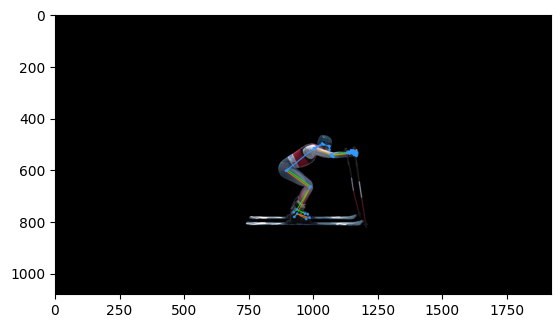

In [4]:
# draw left and right 3d pose in one plot 
# 连线
import sys
import os
import matplotlib.pyplot as plt

sys.path.append('/workspace/code')

from front_side.side.metadata.mhr70 import pose_info as mhr70_pose_info
from front_side.side.visualization.skeleton_visualizer import SkeletonVisualizer

def setup_visualizer():
    """Set up skeleton visualizer with MHR70 pose info."""

    skeleton_visualizer = SkeletonVisualizer(line_width=2, radius=5)
    skeleton_visualizer.set_pose_meta(mhr70_pose_info)
    
    return skeleton_visualizer

parent_dir = os.path.dirname(os.getcwd()) 
sys.path.insert(0, parent_dir)

one_sample = right_outputs[0]
img_vis = one_sample["frame"].copy()

# Set up visualizer
visualizer = setup_visualizer()

print(visualizer.kpt_color.shape)

# Draw keypoints
keypoints_2d = one_sample["pred_keypoints_2d"]
keypoints_2d_vis = np.concatenate(
	[keypoints_2d, np.ones((keypoints_2d.shape[0], 1))], axis=-1
)
img_vis = visualizer.draw_skeleton(image=img_vis, keypoints=keypoints_2d_vis)

plt.imshow(img_vis)


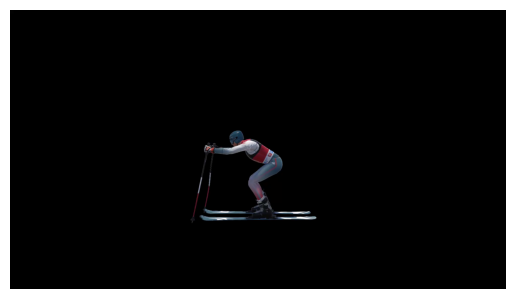

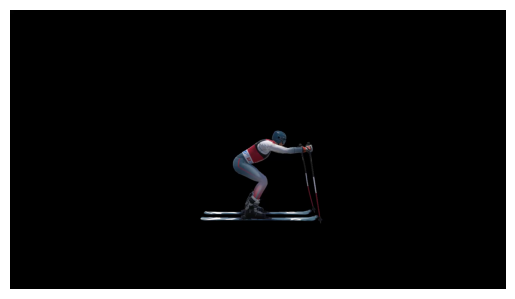

In [27]:
plt.imshow(left_one_sample["frame"])
plt.axis('off')
plt.show()
plt.imshow(right_one_sample["frame"])
plt.axis('off')
plt.show()

(70, 3)


/tmp/ipykernel_1379502/2306070554.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_3d.show()


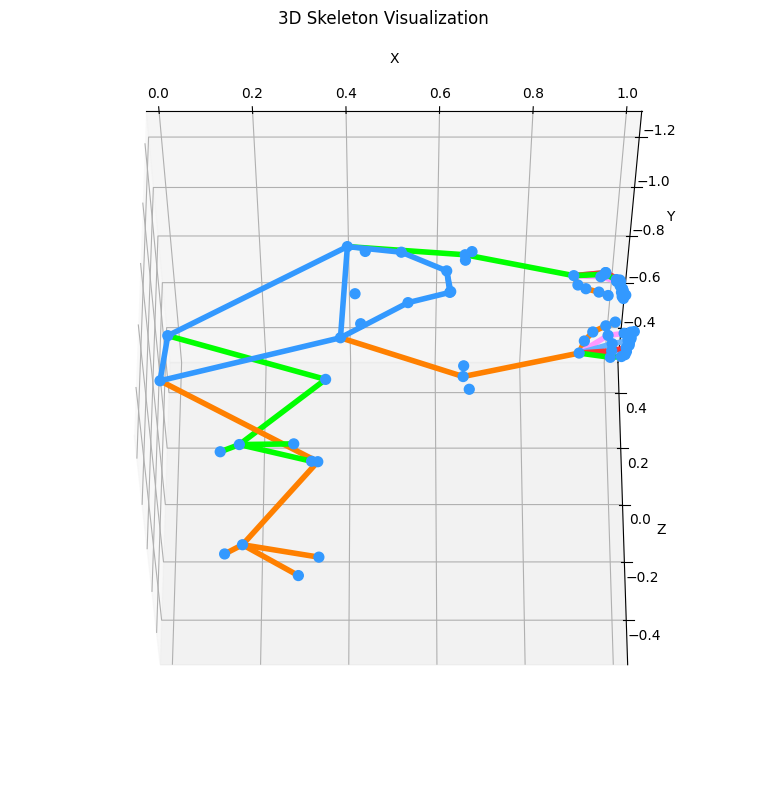

In [5]:
keypoints_3d = one_sample["pred_keypoints_3d"]

print(keypoints_3d.shape)
fig_3d = visualizer.draw_skeleton_3d(ax=None, points_3d=keypoints_3d)

fig_3d.show()

/tmp/ipykernel_1379502/264057375.py:81: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


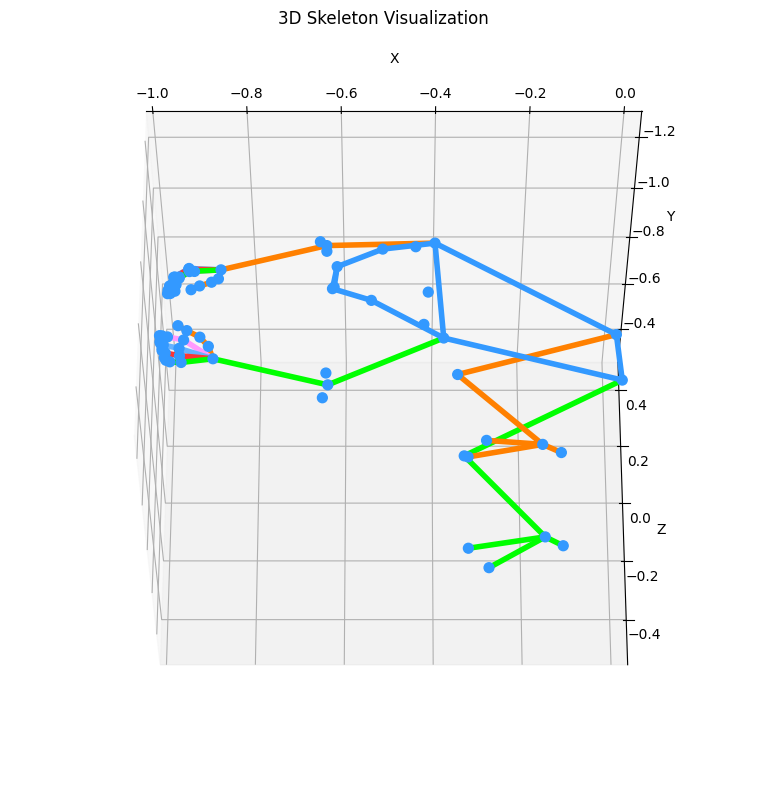

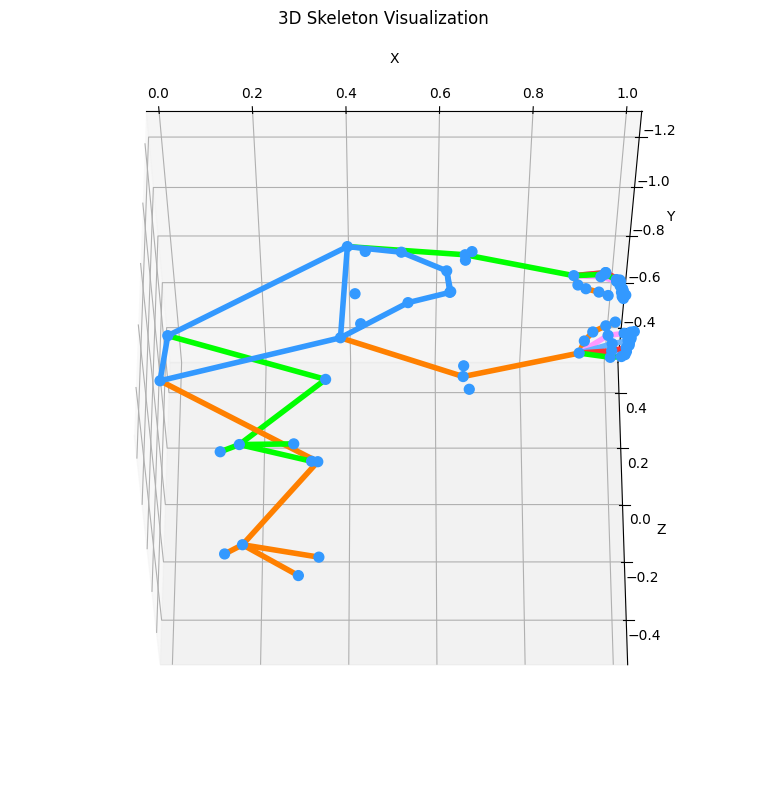

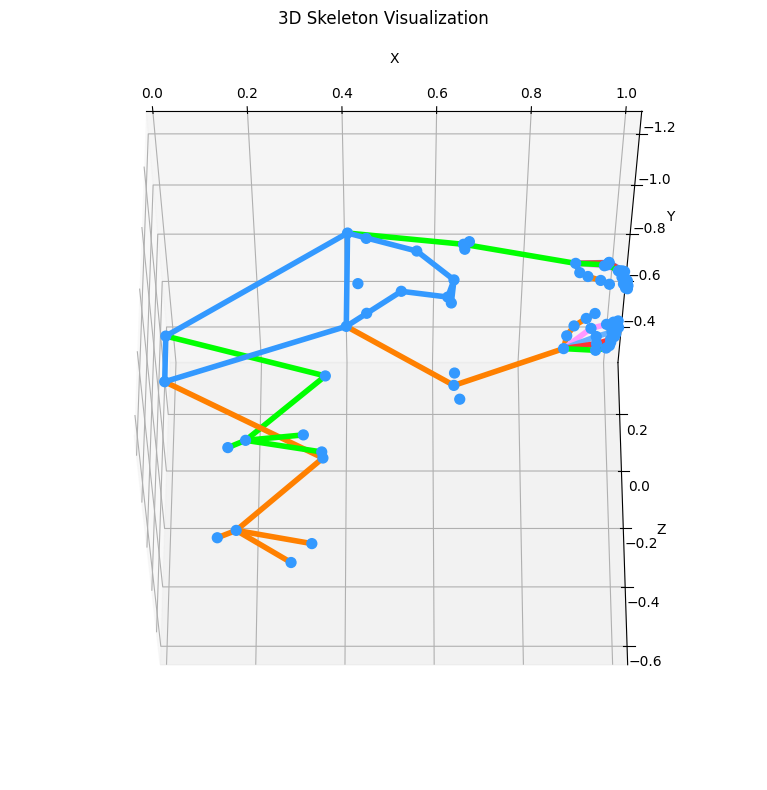

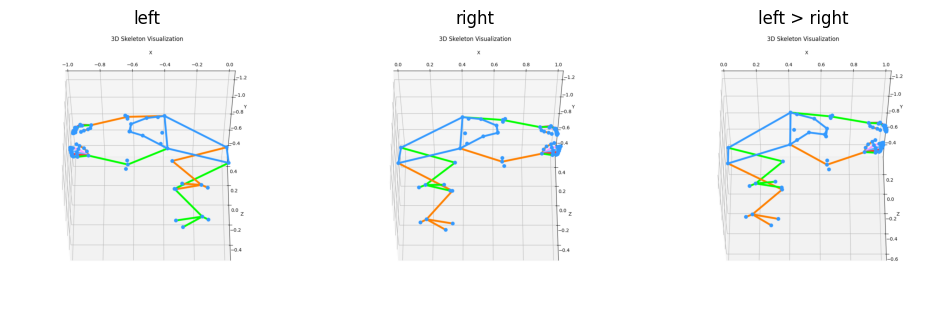

In [6]:
# Visualization of 3D point set alignment with Kabsch (SVD) in NumPy

import numpy as np
import matplotlib.pyplot as plt

# ---------- 2) Helper: rigid transform via SVD (Kabsch) ----------
def rigid_transform_3D(targetr, source):

    assert targetr.shape == source.shape and targetr.shape[1] == 3

    centroid_A = np.mean(targetr, axis=0)
    centroid_B = np.mean(source, axis=0)

    AA = targetr - centroid_A
    BB = source - centroid_B

    H = BB.T @ AA
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T

    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    t = centroid_B - R @ centroid_A
    return R, t

# =========================================================================
# 3) 创建合成示例 (模拟 sam3d_body 的 3D 关键点输入)
# =========================================================================

# 模拟 Ground Truth (Target B)
Lt_n = left_outputs[0]['pred_keypoints_3d']  # 使用左侧关键点作为目标 B
Rt_n = right_outputs[0]['pred_keypoints_3d']  # 使用右侧关键点作为源 A

# print("left_outputs")
# print(left_outputs[0]['pred_cam_t'])
# print(left_outputs[0]['pred_global_rots'])

# print("right_outputs")
# print(right_outputs[0]['pred_cam_t'])
# print(right_outputs[0]['pred_global_rots'])

# ---------- 4) 恢复变换并对齐 ----------
# 将 Source A (Lt_n) 对齐到 Target B (Rt_n)
R, t = rigid_transform_3D(targetr=Rt_n, source=Lt_n)
# print("Rigid Transform:")
# print(R, t)
A_aligned = (Lt_n @ R.T) + t

# 计算对齐误差 (RMSE)
rmse = np.sqrt(np.mean(np.sum((A_aligned - Rt_n)**2, axis=1)))


# Plot BEFORE alignment
fig1 = visualizer.draw_skeleton_3d(ax=None, points_3d=Lt_n)

fig2 = visualizer.draw_skeleton_3d(ax=None, points_3d=Rt_n)

# Plot AFTER alignment
fig3 = visualizer.draw_skeleton_3d(ax=None, points_3d=A_aligned)

def fig_to_array(fig):
    """把 matplotlib Figure 转成 numpy 数组 (RGBA)"""
    fig.canvas.draw()
    data = np.array(fig.canvas.renderer.buffer_rgba())
    return data

# 假设你已有 fig1, fig2, fig3
img1 = fig_to_array(fig1)
img2 = fig_to_array(fig2)
img3 = fig_to_array(fig3)

# 在一个总的 fig 里排成一行三列
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, img, title in zip(axes, [img1, img2, img3], ["left", "right", "left > right"]):
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(title)

fig.show()


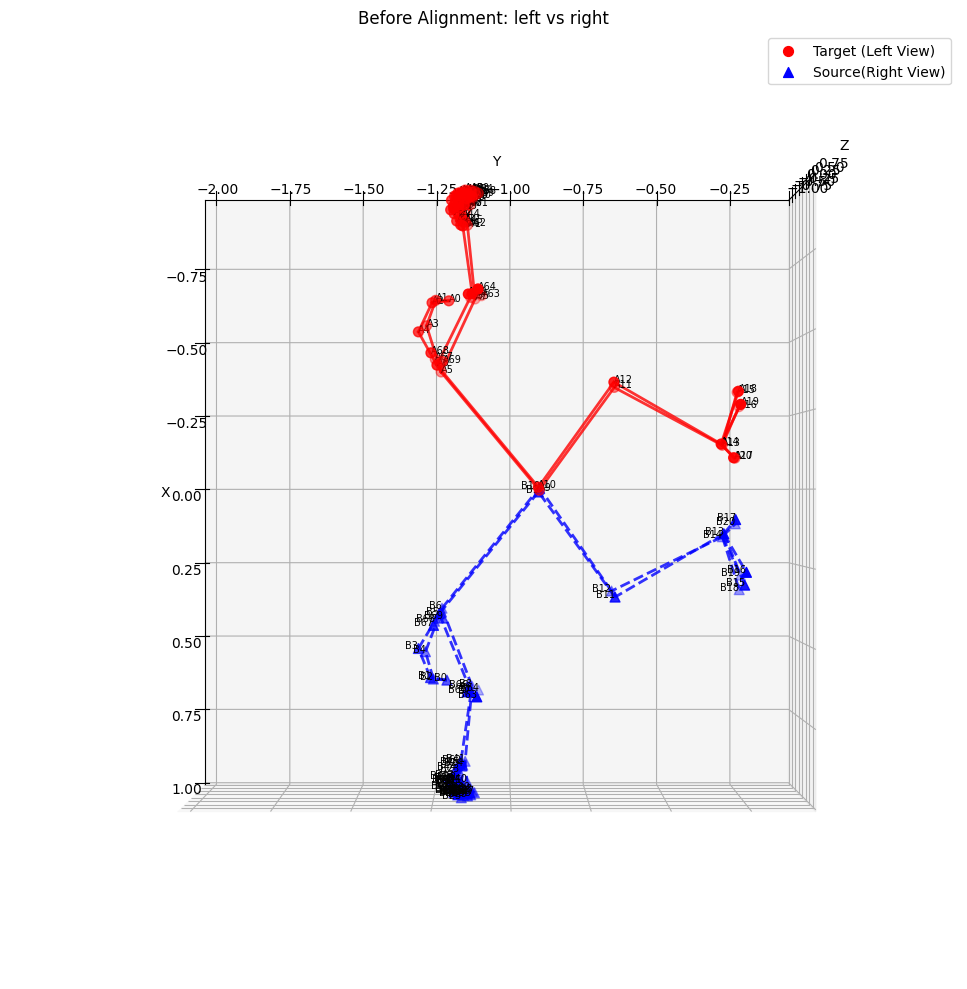

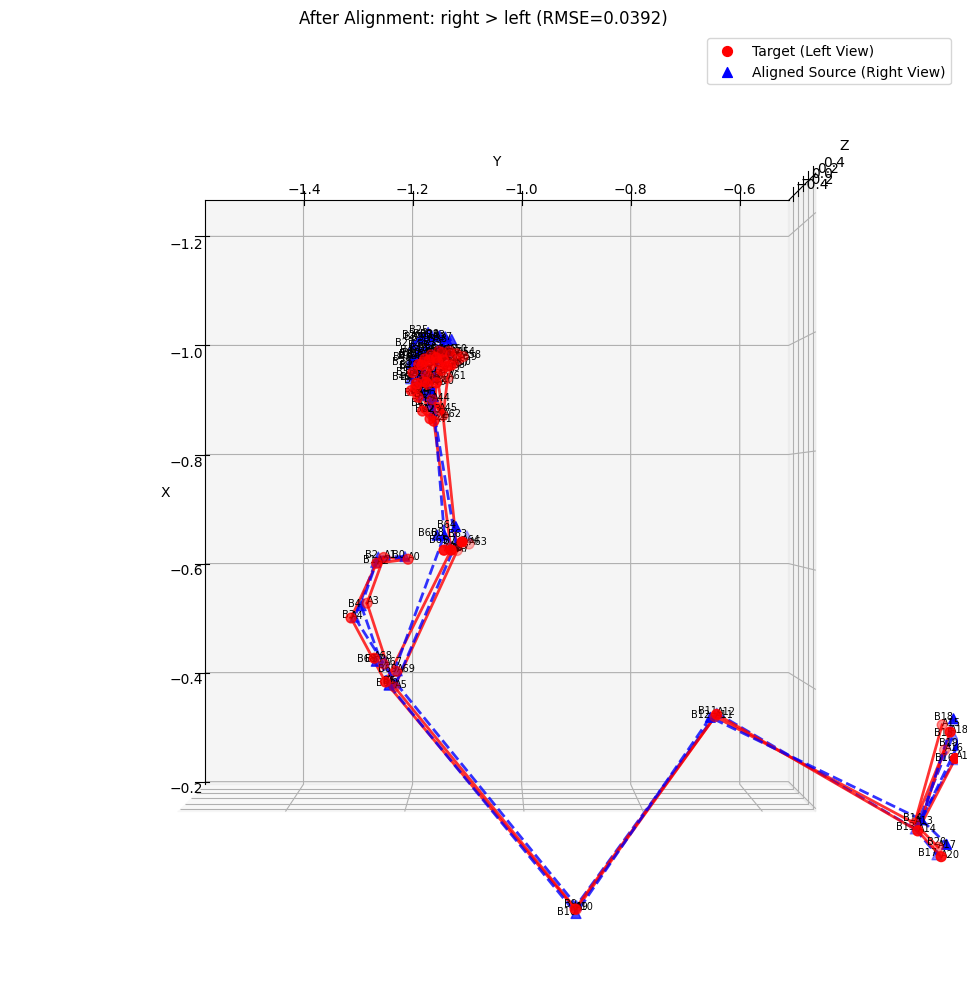

In [16]:
# Visualization of 3D point set alignment with Kabsch (SVD) in NumPy

import numpy as np
import matplotlib.pyplot as plt



# =========================================================================
# 3) 新增绘图函数：同时绘制两个 3D 骨架
# =========================================================================
def plot_3d_skeleton_alignment(A_data, B_data, edges, title, rmse=None, A_label='Source A', B_label='Target B', A_color='red', B_color='blue'):
    """在同一个 3D 图中绘制 Source A 和 Target B 骨架。"""
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(projection='3d')
    
    # 设置标题
    full_title = title
    if rmse is not None:
        full_title += f' (RMSE={rmse:.4f})'
    ax.set_title(full_title)
    
    # --- 绘制 Source A (点和线) ---
    ax.scatter(A_data[:,0], A_data[:,1], A_data[:,2], label=A_label, marker='o', c=A_color, s=50)
    
    # --- 绘制 Target B (点和线) ---
    ax.scatter(B_data[:,0], B_data[:,1], B_data[:,2], label=B_label, marker='^', c=B_color, s=50)

    # 绘制连线
    for a, b in edges:
        # Source A 骨架连线
        ax.plot([A_data[a, 0], A_data[b, 0]],
                [A_data[a, 1], A_data[b, 1]],
                [A_data[a, 2], A_data[b, 2]], c=A_color, alpha=0.8, linewidth=2)
        # Target B 骨架连线
        ax.plot([B_data[a, 0], B_data[b, 0]],
                [B_data[a, 1], B_data[b, 1]],
                [B_data[a, 2], B_data[b, 2]], c=B_color, alpha=0.8, linewidth=2, linestyle='--')
        
    # 标注点的索引（可选，如果点太多可注释掉）
    for i in range(A_data.shape[0]):
        # 标注 Source A 的索引
        ax.text(A_data[i, 0], A_data[i, 1], A_data[i, 2], f"A{i}", color='black', fontsize=7)
        # 标注 Target B 的索引
        ax.text(B_data[i, 0], B_data[i, 1], B_data[i, 2], f"B{i}", color='black', fontsize=7, ha='right')

    # 设置坐标轴标签和范围（保证比例一致）
    all_data = np.vstack([A_data, B_data])
    max_range = np.array([all_data[:, i].max() - all_data[:, i].min() for i in range(3)]).max() / 2.0
    mid = np.mean(all_data, axis=0)
    
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)
    
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.legend()
    ax.view_init(elev=90, azim=0)
    fig.tight_layout()
    return fig


# =========================================================================
# 4) 执行配准和绘图
# =========================================================================

# 模拟 Ground Truth (Target B) 和 Source A
Lt_n = left_outputs[0]['pred_keypoints_3d']    # Source A (预测结果，例如：左摄像头)
Rt_n = right_outputs[0]['pred_keypoints_3d']   # Target B (GT 或另一视图，例如：右摄像头)

# ---------- 配准计算 ----------
R, t = rigid_transform_3D(targetr=Lt_n, source=Rt_n)

# 对齐 Source A
right_aligned = (R @ Rt_n.T).T

# 计算对齐误差 (RMSE)
rmse = np.sqrt(np.mean(np.sum((right_aligned - Lt_n)**2, axis=1)))

# ---------- 绘图展示 ----------

# 1. 配准前对比
# 这里我们要把rt 配准到 lt 的坐标系下，也就是把 rt 当作 source，lt 当作 target
fig_before = plot_3d_skeleton_alignment(
    Lt_n, Rt_n,
    visualizer.skeleton, 
    title='Before Alignment: left vs right',
    A_label='Target (Left View)',
    B_label='Source(Right View)'
)
plt.show(fig_before)

# 2. 配准后对比 (重点查看 RMSE)
fig_after = plot_3d_skeleton_alignment(
    Lt_n, right_aligned, 
    visualizer.skeleton, 
    title='After Alignment: right > left', 
    rmse=rmse,
    A_label='Target (Left View)',
    B_label='Aligned Source (Right View)'
)
plt.show(fig_after)

In [8]:

def plot_person_and_cameras(kpts_world, C_L_world, C_R_world,
                            edges=None, title="Person-centered world"):
    """
    kpts_world: (J, 3) 人体 3D 关键点（以骨盆为原点）
    C_L_world: (3,) 左相机在世界系的位置
    C_R_world: (3,) 右相机在世界系的位置
    edges: 骨架的边列表，例如 [(pelvis, hip_l), (hip_l, knee_l), ...]
    """
    kpts_world = np.asarray(kpts_world)
    C_L_world = np.asarray(C_L_world)
    C_R_world = np.asarray(C_R_world)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # ----- 1. 画骨架点 -----
    X, Y, Z = kpts_world[:, 0], kpts_world[:, 1], kpts_world[:, 2]
    ax.scatter(X, Y, Z, s=20)

    # 如果给了骨架拓扑，就画线连起来
    if edges is not None:
        for i, j in edges:
            xs = [kpts_world[i, 0], kpts_world[j, 0]]
            ys = [kpts_world[i, 1], kpts_world[j, 1]]
            zs = [kpts_world[i, 2], kpts_world[j, 2]]
            ax.plot(xs, ys, zs)

    # 在原点标记骨盆（假设第 0 个是骨盆，可以按你自己的索引改）
    ax.scatter([0], [0], [0], s=60)
    ax.text(0, 0, 0, "pelvis(0,0,0)")

    # ----- 2. 画相机位置 -----
    # 左相机
    ax.scatter(C_L_world[0], C_L_world[1], C_L_world[2], marker='^', s=80)
    ax.text(C_L_world[0], C_L_world[1], C_L_world[2], "Cam L")

    # 右相机
    ax.scatter(C_R_world[0], C_R_world[1], C_R_world[2], marker='s', s=80)
    ax.text(C_R_world[0], C_R_world[1], C_R_world[2], "Cam R")

    # （可选）画一条从相机指向人的线，表示视线大概方向
    ax.plot([C_L_world[0], 0], [C_L_world[1], 0], [C_L_world[2], 0])
    ax.plot([C_R_world[0], 0], [C_R_world[1], 0], [C_R_world[2], 0])

    # ----- 3. 设置坐标轴 -----

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)
    # 你可以在这里调整视角：
    # ax.view_init(elev=20, azim=-60)

    plt.show()

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


# ---------- 工具：保持 3D 坐标轴比例一致 ----------
def set_equal_3d(ax, X, Y, Z):
    max_range = np.array([
        X.max() - X.min(),
        Y.max() - Y.min(),
        Z.max() - Z.min()
    ]).max()
    Xb = 0.5 * (X.max() + X.min())
    Yb = 0.5 * (Y.max() + Y.min())
    Zb = 0.5 * (Z.max() + Z.min())
    ax.set_xlim(Xb - max_range / 2, Xb + max_range / 2)
    ax.set_ylim(Yb - max_range / 2, Yb + max_range / 2)
    ax.set_zlim(Zb - max_range / 2, Zb + max_range / 2)


# ---------- 计算相机视锥体的 4 个角点 ----------
def compute_frustum_points(C, forward, up=np.array([0, 1, 0]),
                           fov_deg=60, depth=1.0):
    """
    C       : (3,) 相机中心（世界系）
    forward : (3,) 相机朝向（需要归一化），例如朝向人物原点的方向
    up      : (3,) 粗略的“向上”方向向量
    fov_deg : 视野角度（大概给个 60° 即可）
    depth   : 视锥体长度（看多远）
    """
    C = np.asarray(C)
    forward = np.asarray(forward)
    forward = forward / (np.linalg.norm(forward) + 1e-8)

    right = np.cross(forward, up)
    right = right / (np.linalg.norm(right) + 1e-8)
    up = np.cross(right, forward)
    up = up / (np.linalg.norm(up) + 1e-8)

    h = depth * np.tan(np.radians(fov_deg) / 2.0)

    p_center = C + forward * depth
    p1 = p_center + right * h + up * h
    p2 = p_center - right * h + up * h
    p3 = p_center - right * h - up * h
    p4 = p_center + right * h - up * h

    return np.stack([p1, p2, p3, p4], axis=0)  # (4,3)


# ---------- 在 3D 里画视锥体 ----------
def draw_frustum(ax, C, frustum_pts, color='r'):
    C = np.asarray(C)
    # 相机中心到四个角点
    for p in frustum_pts:
        ax.plot([C[0], p[0]], [C[1], p[1]], [C[2], p[2]], color=color)

    # 四个角点围成的四边形
    idx = [0, 1, 2, 3, 0]
    for i in range(4):
        a = frustum_pts[idx[i]]
        b = frustum_pts[idx[i + 1]]
        ax.plot([a[0], b[0]], [a[1], b[1]], [a[2], b[2]], color=color)


# ---------- 主函数：画人物 + 左右相机 + 视锥体 ----------
def plot_scene(kpts_world, C_L_world, C_R_world,
               edges=None,
               fov_deg=60,
               frustum_depth=1.0,
			   elev=20, 
               azim=180,
               title="Person-centered world with two cameras"):
    """
    kpts_world : (J,3)  人体 3D 关键点（以骨盆为原点）
    C_L_world  : (3,)   左相机位置（世界系）
    C_R_world  : (3,)   右相机位置（世界系）
    edges      : list[(i,j)] 骨架拓扑，没给的话只画点
    fov_deg    : 视锥 FOV
    frustum_depth : 视锥长度
    """
    kpts_world = np.asarray(kpts_world)
    C_L_world = np.asarray(C_L_world)
    C_R_world = np.asarray(C_R_world)

    X = kpts_world[:, 0]
    Y = kpts_world[:, 1]
    Z = kpts_world[:, 2]

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection="3d")

    # --- 1. 人体骨架 ---
    ax.scatter(X, Y, Z, s=20)
    if edges is not None:
        for i, j in edges:
            xs = [kpts_world[i, 0], kpts_world[j, 0]]
            ys = [kpts_world[i, 1], kpts_world[j, 1]]
            zs = [kpts_world[i, 2], kpts_world[j, 2]]
            ax.plot(xs, ys, zs)

    # 标记骨盆为原点（假设 0 是骨盆）
    ax.scatter([0], [0], [0], s=60)
    ax.text(0, 0, 0, "pelvis(0,0,0)")

    # --- 2. 左相机 ---
    # ax.scatter(C_L_world[0], C_L_world[1], C_L_world[2],
    #            marker='^', s=80, color='r')
    # ax.text(C_L_world[0], C_L_world[1], C_L_world[2], "Cam L", color='r')

    # 朝向：默认看向人物原点
    # dL = -C_L_world
    # dL = dL / (np.linalg.norm(dL) + 1e-8)
    # frustum_L = compute_frustum_points(C_L_world, dL,
    #                                    fov_deg=fov_deg,
    #                                    depth=frustum_depth)
    # draw_frustum(ax, C_L_world, frustum_L, color='r')

    # --- 3. 右相机 ---
    # ax.scatter(C_R_world[0], C_R_world[1], C_R_world[2],
    #            marker='s', s=80, color='b')
    # ax.text(C_R_world[0], C_R_world[1], C_R_world[2], "Cam R", color='b')

    # dR = -C_R_world
    # dR = dR / (np.linalg.norm(dR) + 1e-8)
    # frustum_R = compute_frustum_points(C_R_world, dR,
    #                                    fov_deg=fov_deg,
    #                                    depth=frustum_depth)
    # draw_frustum(ax, C_R_world, frustum_R, color='b')

    # --- 4. 视线（相机到人）的连线（可选） ---
    # ax.plot([C_L_world[0], 0], [C_L_world[1], 0], [C_L_world[2], 0],
    #         linestyle='--', color='r', alpha=0.5)
    # ax.plot([C_R_world[0], 0], [C_R_world[1], 0], [C_R_world[2], 0],
    #         linestyle='--', color='b', alpha=0.5)

    # --- 5. 坐标轴 & 视角 ---
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)

    # 你可以在这里调一下默认视角：
    ax.view_init(elev=elev, azim=azim)

	
	# 翻转 Z 轴显示方向
    # zmin, zmax = ax.get_zlim()
    # ax.set_zlim(zmax, zmin)  # 上下限调换

    ax.set_box_aspect([1,1,1])  # 保持长宽高比例一致


    plt.tight_layout()
    plt.show()


In [10]:
import numpy as np
import plotly.graph_objects as go


def compute_frustum_points(C, forward, up=np.array([0, 1, 0]),
                           fov_deg=60, depth=1.0):
    """计算相机视锥体角点"""
    C = np.asarray(C)
    forward = forward / (np.linalg.norm(forward) + 1e-8)

    right = np.cross(forward, up)
    right = right / (np.linalg.norm(right) + 1e-8)
    up = np.cross(right, forward)
    up = up / (np.linalg.norm(up) + 1e-8)

    h = depth * np.tan(np.radians(fov_deg) / 2)

    p_center = C + forward * depth
    p1 = p_center + right * h + up * h
    p2 = p_center - right * h + up * h
    p3 = p_center - right * h - up * h
    p4 = p_center + right * h - up * h

    return np.stack([p1, p2, p3, p4], axis=0)


def plot_scene_interactive(kpts_world, C_L_world, C_R_world,
                           edges=None,
                           fov_deg=60,
                           frustum_depth=1.0,
                           title="Interactive 3D Scene (Person + Cameras)"):

    fig = go.Figure()

    # -------- 1. 绘制人体骨架 --------
    X, Y, Z = kpts_world[:,0], kpts_world[:,1], kpts_world[:,2]

    fig.add_trace(go.Scatter3d(
        x=X, y=Y, z=Z,
        mode='markers',
        marker=dict(size=4, color='black'),
        name="Joints"
    ))

    # 绘制骨架线条
    if edges is not None:
        for i, j in edges:
            fig.add_trace(go.Scatter3d(
                x=[kpts_world[i,0], kpts_world[j,0]],
                y=[kpts_world[i,1], kpts_world[j,1]],
                z=[kpts_world[i,2], kpts_world[j,2]],
                mode='lines',
                line=dict(color='black', width=3),
                name="bone",
                showlegend=False
            ))

    # -------- 2. 相机方向（默认朝向人体原点） --------
    dL = -C_L_world
    dL = dL / (np.linalg.norm(dL) + 1e-8)
    dR = -C_R_world
    dR = dR / (np.linalg.norm(dR) + 1e-8)

    # -------- 3. 相机视锥体 --------
    frustum_L = compute_frustum_points(C_L_world, forward=dL,
                                       fov_deg=fov_deg, depth=frustum_depth)

    frustum_R = compute_frustum_points(C_R_world, forward=dR,
                                       fov_deg=fov_deg, depth=frustum_depth)

    def add_frustum(fig, C, frustum_pts, color, name):
        # 从相机中心连到 4 个角
        for p in frustum_pts:
            fig.add_trace(go.Scatter3d(
                x=[C[0], p[0]], y=[C[1], p[1]], z=[C[2], p[2]],
                mode='lines',
                line=dict(color=color),
                showlegend=False
            ))
        # 连接四个角
        idx = [0,1,2,3,0]
        for i in range(4):
            a = frustum_pts[idx[i]]
            b = frustum_pts[idx[i+1]]
            fig.add_trace(go.Scatter3d(
                x=[a[0], b[0]], y=[a[1], b[1]], z=[a[2], b[2]],
                mode='lines',
                line=dict(color=color),
                showlegend=False
            ))
        # 画相机中心
        fig.add_trace(go.Scatter3d(
            x=[C[0]], y=[C[1]], z=[C[2]],
            mode='markers+text',
            marker=dict(size=5, color=color),
            text=[name],
            textposition="top center",
            name=name
        ))

    add_frustum(fig, C_L_world, frustum_L, color='red', name="Cam L")
    add_frustum(fig, C_R_world, frustum_R, color='blue', name="Cam R")

    # -------- 4. 布局设置 --------
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title="X",
            yaxis_title="Y",
            zaxis_title="Z",
            aspectmode="data"
        ),
        width=900,
        height=900
    )

    fig.show()


sam 3d 给出的 C_L: [0.23897843 1.1438423  5.1925535 ]
sam 3d 给出的 C_R: [-0.24382238  1.1426476   5.580238  ]
镜像得到的 C_L: [-0.23897843 -1.14384234 -5.19255352]
镜像得到的 C_R: [ 0.24382238 -1.14264762  5.58023787]


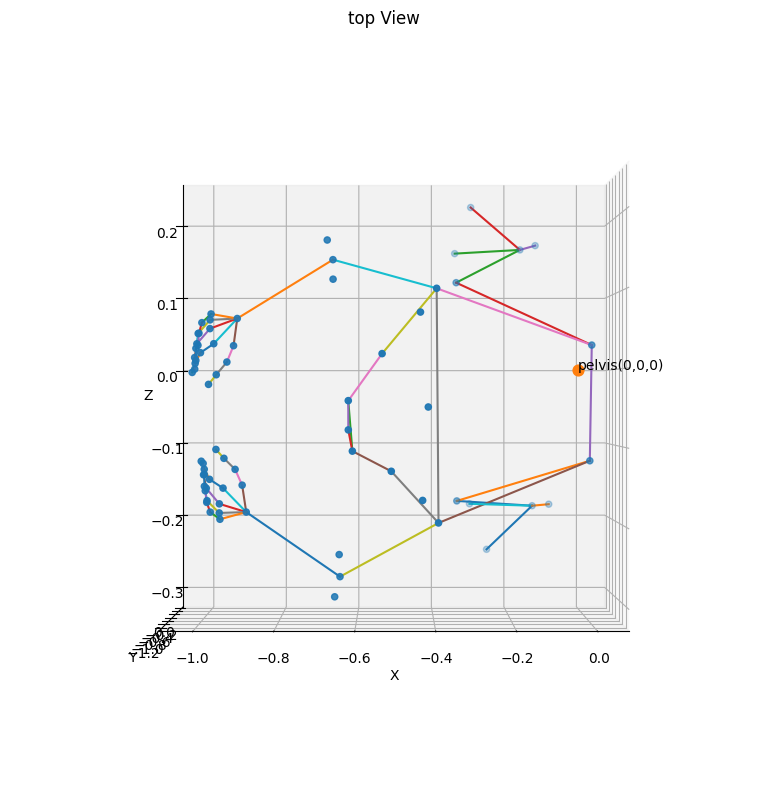

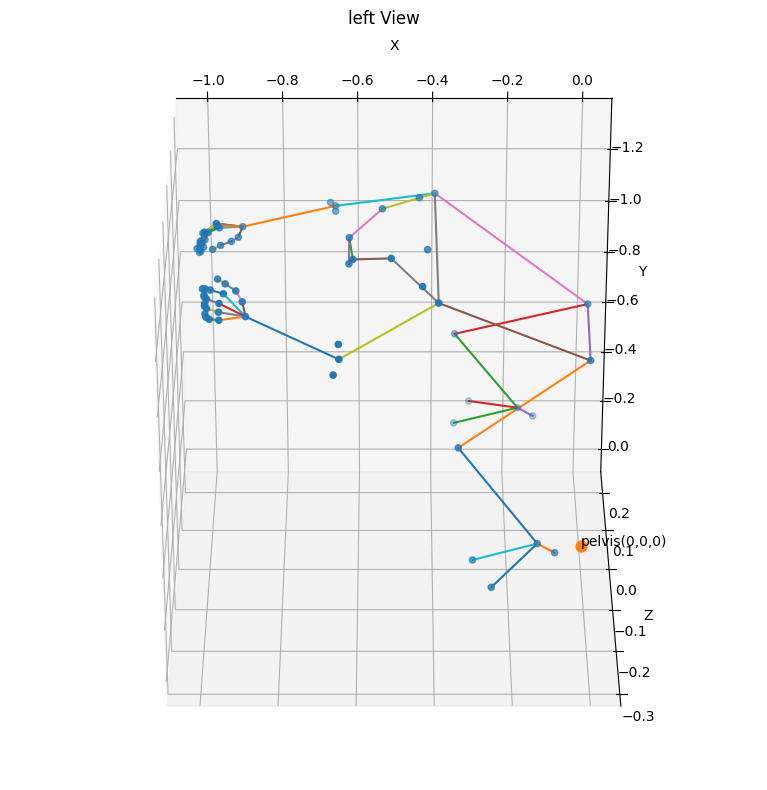

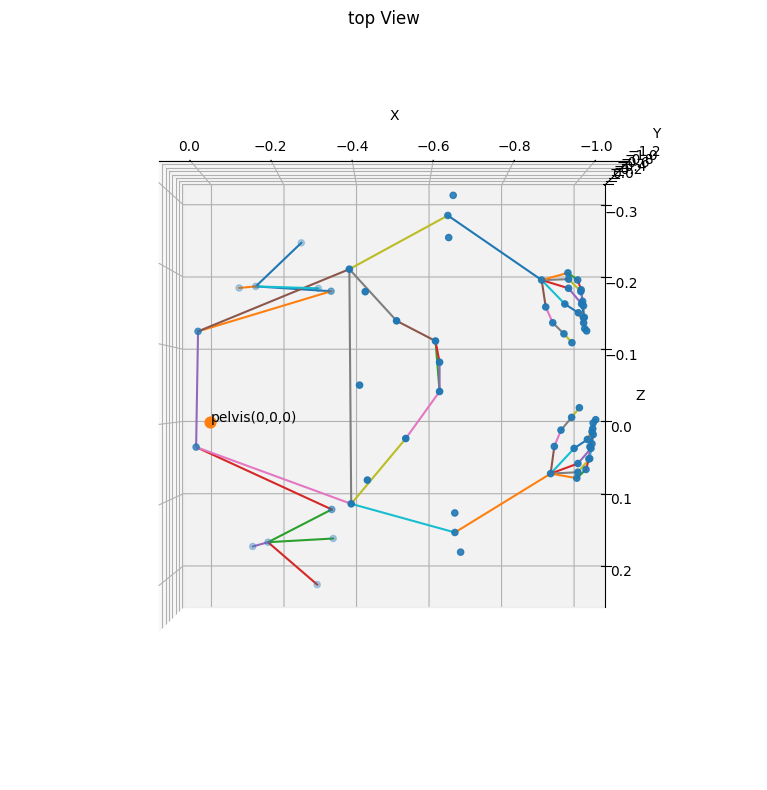

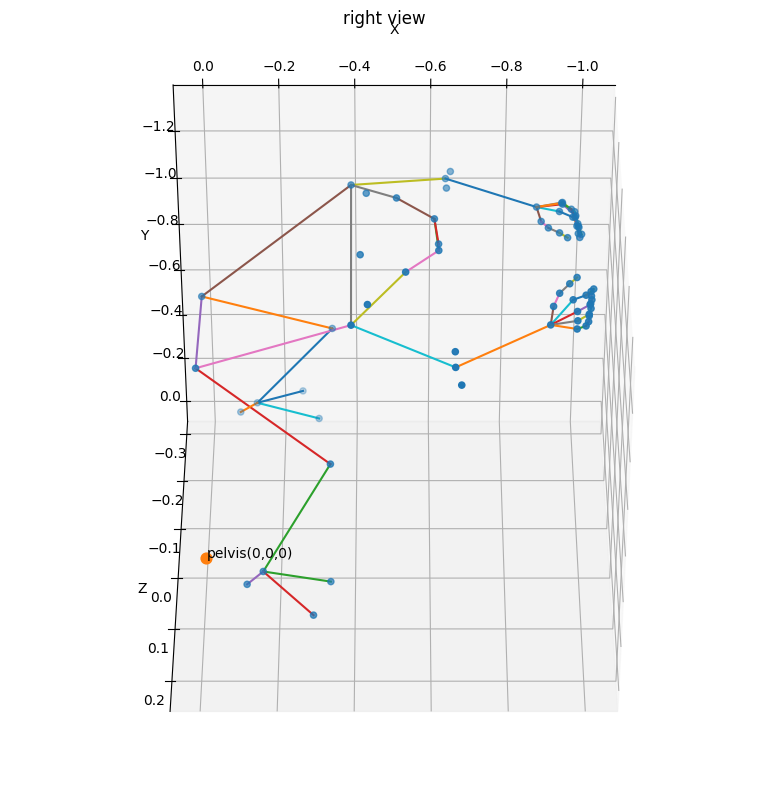

In [19]:

raw_C_L = left_outputs[2]['pred_cam_t']
raw_L_kpt_3d = left_outputs[2]['pred_keypoints_3d']
raw_C_R = right_outputs[2]['pred_cam_t']
raw_R_kpt_3d = right_outputs[2]['pred_keypoints_3d']

print(f"sam 3d 给出的 C_L: {raw_C_L}")
print(f"sam 3d 给出的 C_R: {raw_C_R}")


C_L_mirror = raw_C_L * np.array([-1, -1, -1])
C_R_mirror = raw_C_R * np.array([-1, -1, 1])
print(f"镜像得到的 C_L: {C_L_mirror}")
print(f"镜像得到的 C_R: {C_R_mirror}")


right_aligned = right_aligned

# top left
plot_scene(kpts_world=right_aligned, 
		   C_L_world=C_L_mirror,	C_R_world=C_R_mirror,
		   edges=visualizer.skeleton,
		   title="top View",
		   elev=0, azim=-90,
		   )

# 左面
plot_scene(kpts_world=right_aligned, 
		   C_L_world=C_L_mirror,	C_R_world=C_L_mirror,
		   edges=visualizer.skeleton,
           title="left View",
           elev=-60, azim=-90,
		   )

# top right
plot_scene(kpts_world=right_aligned, 
		   C_L_world=C_L_mirror,	C_R_world=C_R_mirror,
		   edges=visualizer.skeleton,
		   title="top View",
		   elev=180, azim=90,
		   )


# 右面 -270, -90
plot_scene(kpts_world=right_aligned, 
		   C_L_world=C_L_mirror,	C_R_world=C_R_mirror,
		   edges=visualizer.skeleton,
		   elev=130, azim=90,
			title="right view"
			)



In [12]:
for frame_idx in range(len(left_outputs)):
	print(f"Frame {frame_idx}:")

	raw_C_L = left_outputs[frame_idx]['pred_cam_t']
	raw_L_kpt_3d = left_outputs[frame_idx]['pred_keypoints_3d'] # target 
	raw_C_R = right_outputs[frame_idx]['pred_cam_t']
	raw_R_kpt_3d = right_outputs[frame_idx]['pred_keypoints_3d'] # source

	# ---------- 配准计算 ----------
	R, t = rigid_transform_3D(targetr=raw_L_kpt_3d, source=raw_R_kpt_3d)

	# 对齐 Source A
	right_aligned = (raw_R_kpt_3d @ R.T) + t

	# 计算对齐误差 (RMSE)
	rmse = np.sqrt(np.mean(np.sum((right_aligned - raw_L_kpt_3d)**2, axis=1)))
	print(f"  RMSE: {rmse:.4f}")

	print(f"sam 3d 给出的 C_L: {raw_C_L}")
	print(f"sam 3d 给出的 C_R: {raw_C_R}")


	C_L_mirror = raw_C_L * np.array([-1, -1, -1])
	C_R_mirror = raw_C_R * np.array([-1, -1, 1])
	C_R_aligned = (-raw_C_R @ R.T) + t

	print(f"镜像得到的 C_L: {C_L_mirror}")
	print(f"镜像得到的 C_R: {C_R_mirror}")
	print(f"刚体变换之后的 C_R_world: {C_R_aligned}")

	print("-" * 30)

	# # top 
	# plot_scene(kpts_world=raw_L_kpt_3d, 
	# 		C_L_world=C_L_mirror,	C_R_world=C_R_mirror,
	# 		edges=visualizer.skeleton,
	# 		title="top View",
	# 		elev=0, azim=270,
	# 		)

	# # 右面 -270, -90
	# plot_scene(kpts_world=raw_L_kpt_3d, 
	# 		C_L_world=C_R_mirror,	C_R_world=C_R_mirror,
	# 		edges=visualizer.skeleton,
	# 		elev=-270, azim=-90,
	# 			title="right view"
	# 			)

	# # 左面90， 90  	
	# plot_scene(kpts_world=raw_L_kpt_3d, 
	# 		C_L_world=C_L_mirror,	C_R_world=C_L_mirror,
	# 		edges=visualizer.skeleton,
	# 		title="left View",
	# 		elev=-90, azim=-90,
	# 		)


Frame 0:
  RMSE: 0.0952
sam 3d 给出的 C_L: [0.2396333 1.1441771 5.179871 ]
sam 3d 给出的 C_R: [-0.24462475  1.144161    5.5594296 ]
镜像得到的 C_L: [-0.23963331 -1.14417708 -5.17987108]
镜像得到的 C_R: [ 0.24462475 -1.14416099  5.55942965]
刚体变换之后的 C_R_world: [-0.5575546 -1.4149976  5.398514 ]
------------------------------
Frame 1:
  RMSE: 0.0931
sam 3d 给出的 C_L: [0.23959109 1.1436929  5.1993933 ]
sam 3d 给出的 C_R: [-0.2440704  1.143456   5.6384773]
镜像得到的 C_L: [-0.23959109 -1.14369285 -5.19939327]
镜像得到的 C_R: [ 0.2440704  -1.14345598  5.63847733]
刚体变换之后的 C_R_world: [-0.5440951 -1.4763986  5.480212 ]
------------------------------
Frame 2:
  RMSE: 0.0970
sam 3d 给出的 C_L: [0.23897843 1.1438423  5.1925535 ]
sam 3d 给出的 C_R: [-0.24382238  1.1426476   5.580238  ]
镜像得到的 C_L: [-0.23897843 -1.14384234 -5.19255352]
镜像得到的 C_R: [ 0.24382238 -1.14264762  5.58023787]
刚体变换之后的 C_R_world: [-0.56140584 -1.4535526   5.415554  ]
------------------------------
Frame 3:
  RMSE: 0.1823
sam 3d 给出的 C_L: [0.2384907 1.145264  5.2325

In [13]:
for frame_idx in range(len(left_outputs)):
	print(f"Frame {frame_idx}:")

	raw_C_L = left_outputs[frame_idx]['pred_cam_t']
	raw_L_kpt_3d = left_outputs[frame_idx]['pred_keypoints_3d'] # target 
	raw_C_R = right_outputs[frame_idx]['pred_cam_t']
	raw_R_kpt_3d = right_outputs[frame_idx]['pred_keypoints_3d'] # source

	print(f"sam 3d 给出的 C_L: {raw_C_L}")
	print(f"sam 3d 给出的 C_R: {raw_C_R}")

	# ---------- 配准计算 ----------
	R, t = rigid_transform_3D(targetr=raw_L_kpt_3d, source=raw_R_kpt_3d)

	# 对齐 Source A
	right_aligned = (raw_R_kpt_3d @ R.T) 

	# 计算对齐误差 (RMSE)
	rmse = np.sqrt(np.mean(np.sum((right_aligned - raw_L_kpt_3d)**2, axis=1)))

	print("-" * 30)
	print(f"right to left  RMSE: {rmse:.4f}")

	C_L_mirror = raw_C_L * np.array([-1, -1, -1])
	C_R_mirror = raw_C_R * np.array([-1, -1, 1])
	C_R_aligned = (raw_C_R @ R.T)

	print(f"镜像得到的 C_L: {C_L_mirror}")
	print(f"镜像得到的 C_R: {C_R_mirror}")
	print(f"刚体变换之后的 C_R_world: {C_R_aligned}")
	print(f"中心点的差异: {C_R_aligned - C_R_mirror}")

	print("-" * 30)

Frame 0:
sam 3d 给出的 C_L: [0.2396333 1.1441771 5.179871 ]
sam 3d 给出的 C_R: [-0.24462475  1.144161    5.5594296 ]
------------------------------
right to left  RMSE: 0.0392
镜像得到的 C_L: [-0.23963331 -1.14417708 -5.17987108]
镜像得到的 C_R: [ 0.24462475 -1.14416099  5.55942965]
刚体变换之后的 C_R_world: [ 0.5776646  1.4106854 -5.4728856]
中心点的差异: [  0.33303986   2.55484641 -11.03231525]
------------------------------
Frame 1:
sam 3d 给出的 C_L: [0.23959109 1.1436929  5.1993933 ]
sam 3d 给出的 C_R: [-0.2440704  1.143456   5.6384773]
------------------------------
right to left  RMSE: 0.0477
镜像得到的 C_L: [-0.23959109 -1.14369285 -5.19939327]
镜像得到的 C_R: [ 0.2440704  -1.14345598  5.63847733]
刚体变换之后的 C_R_world: [ 0.56180614  1.470696   -5.5390353 ]
中心点的差异: [  0.31773575   2.61415195 -11.17751265]
------------------------------
Frame 2:
sam 3d 给出的 C_L: [0.23897843 1.1438423  5.1925535 ]
sam 3d 给出的 C_R: [-0.24382238  1.1426476   5.580238  ]
------------------------------
right to left  RMSE: 0.0446
镜像得到的 C_L: [-0.23897

In [14]:
# kpts3d_left: (J,3)   左视角的 3D kpt（已经以骨盆对齐）
# pred_cam_t_left, pred_cam_t_right: (3,)
# s, R_RL, t_RL: 用 Umeyama 求出的 右→左 相似变换

# 世界系 = 左人系
s = 1.0
R_RL = R 
t_RL = t

C_L_world = left_outputs[0]['pred_cam_t']
C_R_person = right_outputs[0]['pred_cam_t']
print(f"sam 3d 给出的 C_L_person: {C_L_world}")
print(f"sam 3d 给出的 C_R_person: {C_R_person}")

C_L_world = C_L_world * np.array([-1, -1, -1])  # 关于原点镜像
C_R_person = C_R_person * np.array([-1, -1, -1])  # 关于 Y 轴镜像

C_R_world = s * (R_RL @ C_R_person) + t_RL

C_R_mirror = C_R_person.copy()
C_R_mirror[0] = -C_R_mirror[0]  # 关于
C_R_mirror[2] = -C_R_mirror[2]  # 关于 Z 轴镜像

print(f"镜像变换之后的 C_R_mirror: {C_R_mirror}")
print(f"刚体变换之后的 C_R_world: {C_R_world}")

kpts_world = A_aligned  # 直接把左视角的人当作世界里的骨架

plot_scene_interactive(kpts_world=raw_L_kpt_3d, C_L_world=C_L_world, C_R_world=C_R_world,
					   edges=visualizer.skeleton,fov_deg=60,
					   frustum_depth=1.0,
					   title="Interactive 3D Scene (Person + Cameras)")

sam 3d 给出的 C_L_person: [0.2396333 1.1441771 5.179871 ]
sam 3d 给出的 C_R_person: [-0.24462475  1.144161    5.5594296 ]
镜像变换之后的 C_R_mirror: [-0.24462475 -1.14416099  5.55942965]
刚体变换之后的 C_R_world: [-0.33800975 -0.63413969  5.50822921]


raw_c_l_world: [0.17599574 1.0142578  3.844588  ]
raw_c_r_world: [-0.17263389  1.0141706   4.8455663 ]
调整后 raw_c_l_world: [ 0.17599574 -1.0142578   3.844588  ]
调整后 raw_c_r_world: [ 0.17263389 -1.0141706  -4.8455663 ]


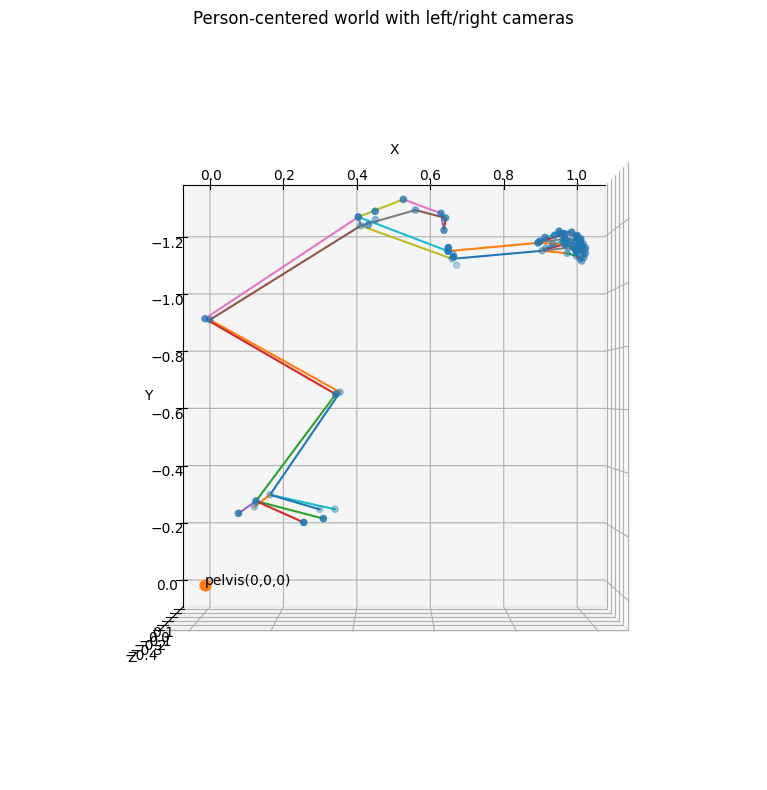

In [15]:
raw_c_l_world = left_outputs[105]['pred_cam_t']
raw_c_r_world = right_outputs[105]['pred_cam_t']
raw_kpts_world = left_outputs[105]['pred_keypoints_3d']

print("raw_c_l_world:", raw_c_l_world)
print("raw_c_r_world:", raw_c_r_world)

# 世界坐标是按照做相机的坐标系来定的
# 任务要求y轴向上，而做相机的y轴是向下的，所以两个相机都需要反转y轴
# 所以左相机的位置，只需要反转y
# 右相机的话，因为是根据z轴对称的，所以需要反转x，z轴，加上y轴的话，就是整体取反
raw_c_l_world[1] = -raw_c_l_world[1]
raw_c_r_world = -raw_c_r_world

# matplot 的z是反的
# raw_c_l_world[2] = -raw_c_l_world[2]
# raw_c_r_world[2] = -raw_c_r_world[2]

print("调整后 raw_c_l_world:", raw_c_l_world)
print("调整后 raw_c_r_world:", raw_c_r_world)

plot_scene(kpts_world, raw_c_l_world, raw_c_r_world,
           edges=visualizer.skeleton,
           fov_deg=60,
           frustum_depth=0.5,
           elev=-90,
           azim=270,
           title="Person-centered world with left/right cameras")

plot_scene_interactive(raw_kpts_world, raw_c_l_world, raw_c_r_world,
					   edges=visualizer.skeleton,fov_deg=60,
					   frustum_depth=0.5,
					   title="Interactive 3D Scene (Person + Cameras)")